# 策略梯度 - cartpole

In [1]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from collections import defaultdict
import os
import sys
file_dir_name = os.path.dirname(os.getcwd())
if file_dir_name not in sys.path:
    sys.path.append(file_dir_name)
from package import rl_utils

定义策略网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.Net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.Net(x)

定义算法

In [3]:
class REINFORCE:
    def __init__(self, config):
        self.policy_net = PolicyNet(config.nS, config.hidden_dim, config.nA).to(config.device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=config.learning_rate)
        self.gamma = config.gamma
        self.device = config.device
    
    def sample_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        probs = self.policy_net(state.reshape(1,-1))
        action_dist = torch.distributions.Categorical(probs)
        return action_dist.sample().item() # sample返回一个tensor, item返回一个数字 (第几个action)

    def update(self, transition_dict):
        reward_list = transition_dict['reward']
        state_list = transition_dict['state']
        action_list = transition_dict['action']
        
        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor(state_list[i], dtype=torch.float32).to(self.device)
            action = torch.tensor(action_list[i]).to(self.device)
            log_prob = torch.log(self.policy_net(state.reshape(1,-1))[0, action])
            G = self.gamma * G + reward
            loss = -log_prob * G
            loss.backward()
        self.optimizer.step()

定义配置

In [4]:
class Configuration():
    def __init__(self, env):
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n
        self.device = torch.device('cuda')
        self.gamma = 0.98
        self.learning_rate = 1e-3
        self.hidden_dim = 128
        self.env = env
        self.epochs = 1000

env = gym.make('CartPole-v1')
config = Configuration(env)
agent = REINFORCE(config)

In [5]:
def train(config, env, agent):
    rewards = []
    tqdm_iter = tqdm(range(config.epochs))
    for i in tqdm_iter:
        trainsition = defaultdict(list)
        tqdm_iter.set_description(f'train [ {i+1}/{config.epochs} ]')
        state = env.reset()[0]
        while True:
            action = agent.sample_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            trainsition['state'].append(state)
            trainsition['reward'].append(reward)
            trainsition['action'].append(action)
            state = next_state
            if terminated or truncated:
                break
        agent.update(trainsition)
        rewards.append(np.sum(trainsition['reward']))
        tqdm_iter.set_postfix(reward=f'{np.mean(rewards[-10:])}')
        tqdm_iter.update()
    return rewards

In [6]:
rewards = train(config, env, agent)

train [ 1000/1000 ]: 100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s, reward=446.8]         


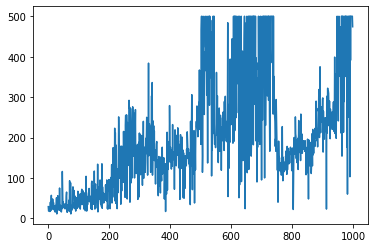

In [7]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(rewards))), rewards);

193405.0 193.405


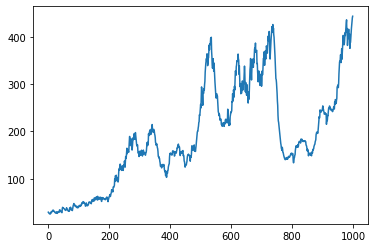

In [8]:
def smooth(data, weight=0.9):  
    last = data[0]
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

plt.plot(list(range(len(rewards))), smooth(rewards));
print(np.sum(rewards), np.mean(rewards))

都是看运气, 不是特别好说的, baseline不一定比这个好